In [40]:
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import graphs

import process as pp
import db_connect

%load_ext autoreload
%autoreload 2

connection = db_connect.start_conn()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Visualization

In [19]:
# Getting Data
query1 = """
SELECT EXTRACT(YEAR FROM "SALE DATE") as year, 
       "BOROUGH",
       COUNT(*) as count
FROM rolling_sales
GROUP BY EXTRACT(YEAR FROM "SALE DATE"), "BOROUGH"
ORDER BY year, "BOROUGH"
"""
annual_byBoro = pl.read_database(query = query1, connection = connection)
annual_byBoro_roc = annual_byBoro.sort(["BOROUGH", "year"]).with_columns(
    (pl.col("count").pct_change().over("BOROUGH")*100).alias("roc")
)
annual_sales=annual_byBoro.group_by("year").agg(pl.col("count").sum().alias("count")).sort("year")
annual_sales_roc=annual_sales.sort("year").with_columns(
    (pl.col("count").pct_change()*100).alias("roc")
)

annual_byBoro_pd = annual_byBoro.to_pandas()
annual_byBoro_roc_pd = annual_byBoro_roc.to_pandas()
annual_sales_pd = annual_sales.to_pandas()
annual_sales_roc_pd = annual_sales_roc.to_pandas()

borough_names = {
    1: "Manhattan", 
    2: "Bronx", 
    3: "Brooklyn", 
    4: "Queens", 
    5: "Staten Island"
}

annual_byBoro_pd['borough_name'] = annual_byBoro_pd['BOROUGH'].map(borough_names)
annual_byBoro_roc_pd['borough_name'] = annual_byBoro_roc_pd['BOROUGH'].map(borough_names)

In [54]:
annual_sales_roc_pd

,year,count,roc
0,2003,118428,NaN
1,2004,126591,6.892796
2,2005,123643,-2.328760
3,2006,115472,-6.608542
4,2007,107009,-7.329049
5,2008,91147,-14.823052
6,2009,74995,-17.720825
7,2010,69036,-7.945863
8,2011,73525,6.502405
9,2012,84081,14.357021


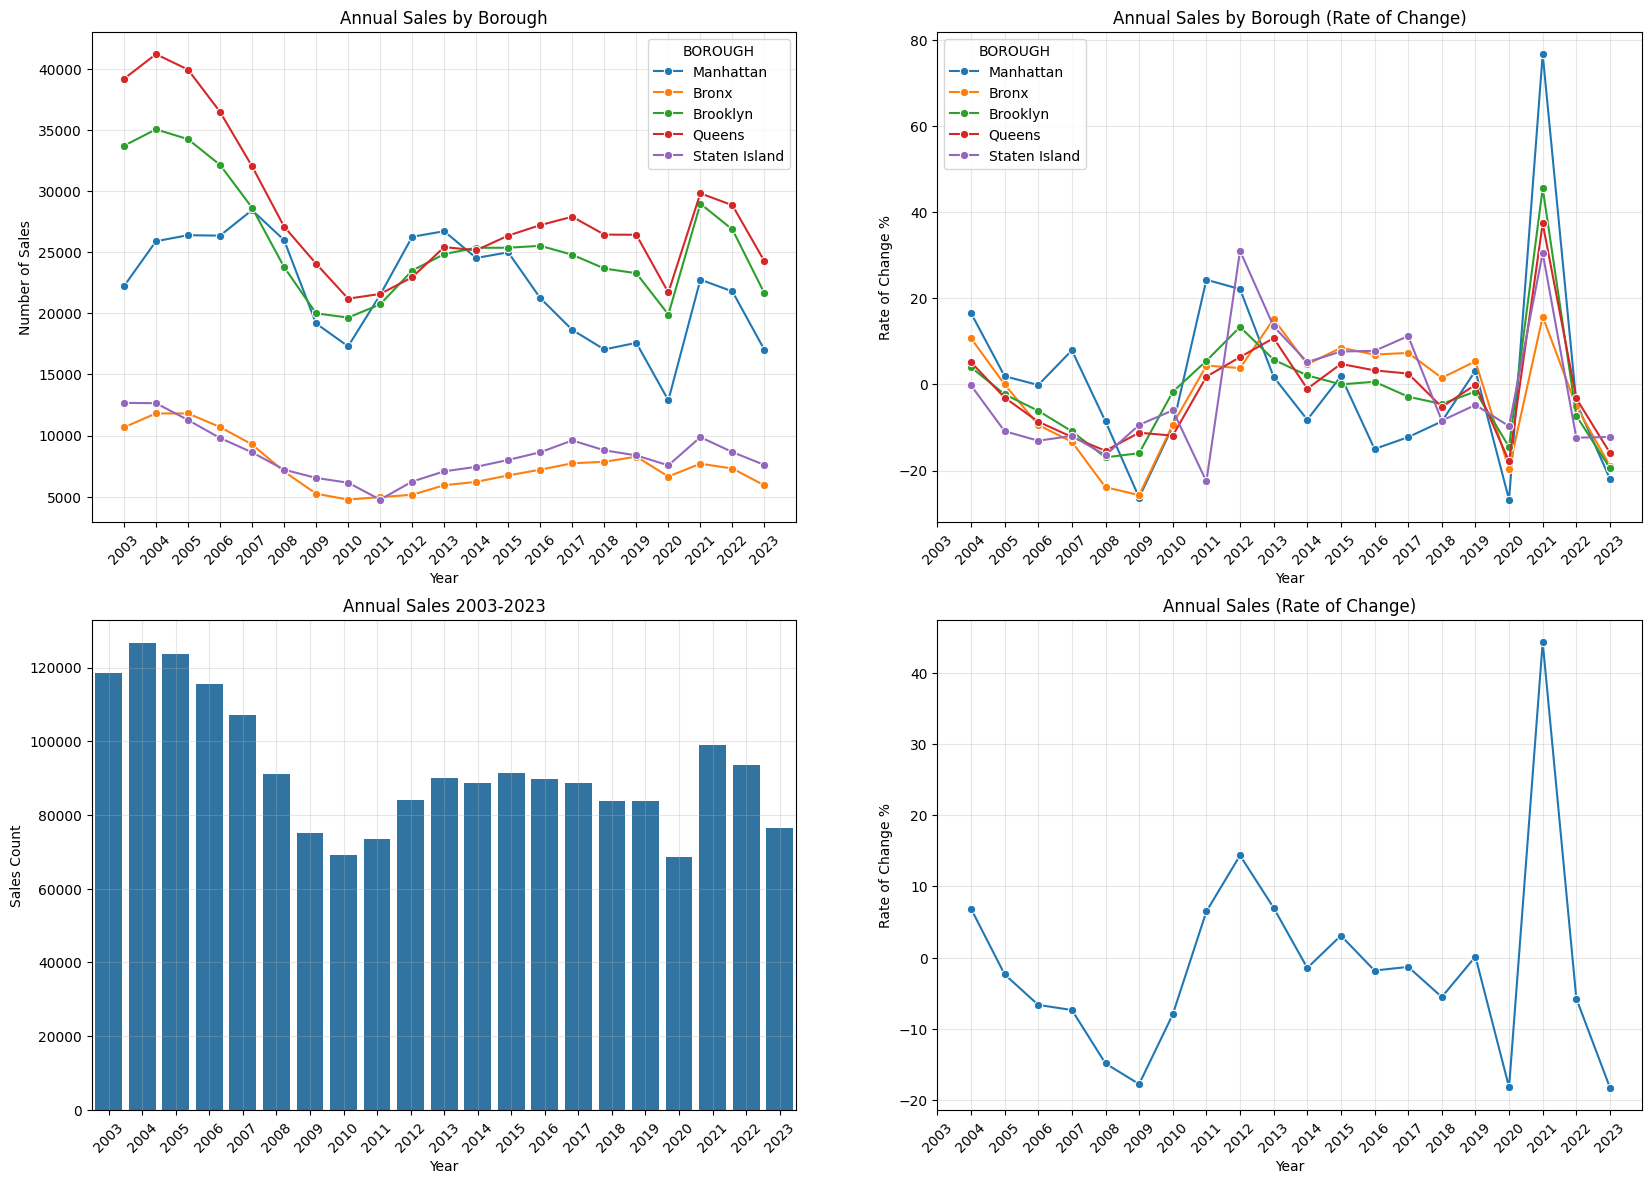

In [57]:
fig, axs = plt.subplots(2,2)

graphs.MatPlot.makePlot(
    chart='line',
    data=annual_byBoro_pd,
    x='year',
    y='count',
    hue='BOROUGH',
    palette=["C0", "C1", "C2", "C3", "C4"],
    title='Annual Sales by Borough',
    xticks=sorted(annual_byBoro_pd['year'].unique()),
    xlabel='Year',
    xrot=45,
    ylabel='Number of Sales',
    leg_on=True,
    leg_pos='upper right',
    leg_outer=False,
    leg_labels=annual_byBoro_pd['borough_name'].unique(),
    ax = axs[0,0]
)

graphs.MatPlot.makePlot(
    chart='line',
    data=annual_byBoro_roc_pd,
    x='year',
    y='roc',
    hue='BOROUGH',
    palette=["C0", "C1", "C2", "C3", "C4"],
    title='Annual Sales by Borough (Rate of Change)',
    xticks=sorted(annual_byBoro_pd['year'].unique()),
    xlabel='Year',
    xrot=45,
    ylabel='Rate of Change %',
    leg_on=True,
    leg_pos='upper left',
    leg_outer=False,
    leg_labels=annual_byBoro_pd['borough_name'].unique(),
    ax = axs[0,1]
)

graphs.MatPlot.makePlot(
    chart='bar',
    data=annual_sales_pd,
    x='year',
    y='count',
    title='Annual Sales 2003-2023',
    xticks=[str(year) for year in annual_sales['year']],
    xlabel='Year',
    xrot=45,
    ylabel='Sales Count',
    leg_on=False,
    ax=axs[1,0]
)

graphs.MatPlot.makePlot(
    chart='line',
    data=annual_sales_roc_pd,
    x='year',
    y='roc',
    title='Annual Sales (Rate of Change)',
    xticks=annual_sales_roc_pd['year'],
    xlabel='Year',
    xrot=45,
    ylabel='Rate of Change %',
    leg_on=False,
    ax=axs[1,1]
)

fig.set_figheight(14)
fig.set_figwidth(20)

In [4]:
fig = make_subplots(
    rows=2, 
    cols=2,
    subplot_titles=(
        'Annual Sales by Borough', 
        'Annual Sales by Borough (Rate of Change)', 
        'Annual Sales 2003 - 2023', 
        'Annual Sales (Rate of Change)'
    )
)

for borough in annual_byBoro_pd['BOROUGH'].unique():
    df_borough = annual_byBoro_pd[annual_byBoro_pd['BOROUGH'] == borough]
    fig.add_trace(
        go.Scatter(
            x=df_borough['year'],
            y=df_borough['count'],
            mode='lines+markers',
            name=f"{borough} : {borough_names.get(borough, '')}",
            hovertemplate='Year: %{x}<br>Sales: %{y}<br>Borough: %{text}<extra></extra>',
            text=df_borough['borough_name']
        ),
        row=1, col=1
    )

for borough in annual_byBoro_roc_pd['BOROUGH'].unique():
    df_borough = annual_byBoro_roc_pd[annual_byBoro_roc_pd['BOROUGH'] == borough]
    fig.add_trace(
        go.Scatter(
            x=df_borough['year'],
            y=df_borough['roc'],
            mode='lines+markers',
            name=f"{borough} : {borough_names.get(borough, '')}",
            hovertemplate='Year: %{x}<br>Rate of Change: %{y:.2f}%<br>Borough: %{text}<extra></extra>',
            text=df_borough['borough_name'],
            showlegend=False
        ),
        row=1, col=2
    )

fig.add_trace(
    go.Bar(
        x=annual_sales_pd['year'],
        y=annual_sales_pd['count'],
        hovertemplate='Year: %{x}<br>Total Sales: %{y}<extra></extra>'
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=annual_sales_roc_pd['year'],
        y=annual_sales_roc_pd['roc'],
        mode='lines+markers',
        hovertemplate='Year: %{x}<br>Rate of Change: %{y:.2f}%<extra></extra>'
    ),
    row=2, col=2
)

fig.update_layout(
    height=800,
    width=1200,
    title_text="NYC Rolling Sales Analysis",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.update_xaxes(tickangle=45)
fig.update_yaxes(title_text="Number of Sales", row=1, col=1)
fig.update_yaxes(title_text="Rate of Change (%)", row=1, col=2)
fig.update_yaxes(title_text="Number of Sales", row=2, col=1)
fig.update_yaxes(title_text="Rate of Change (%)", row=2, col=2)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)')

fig.show()

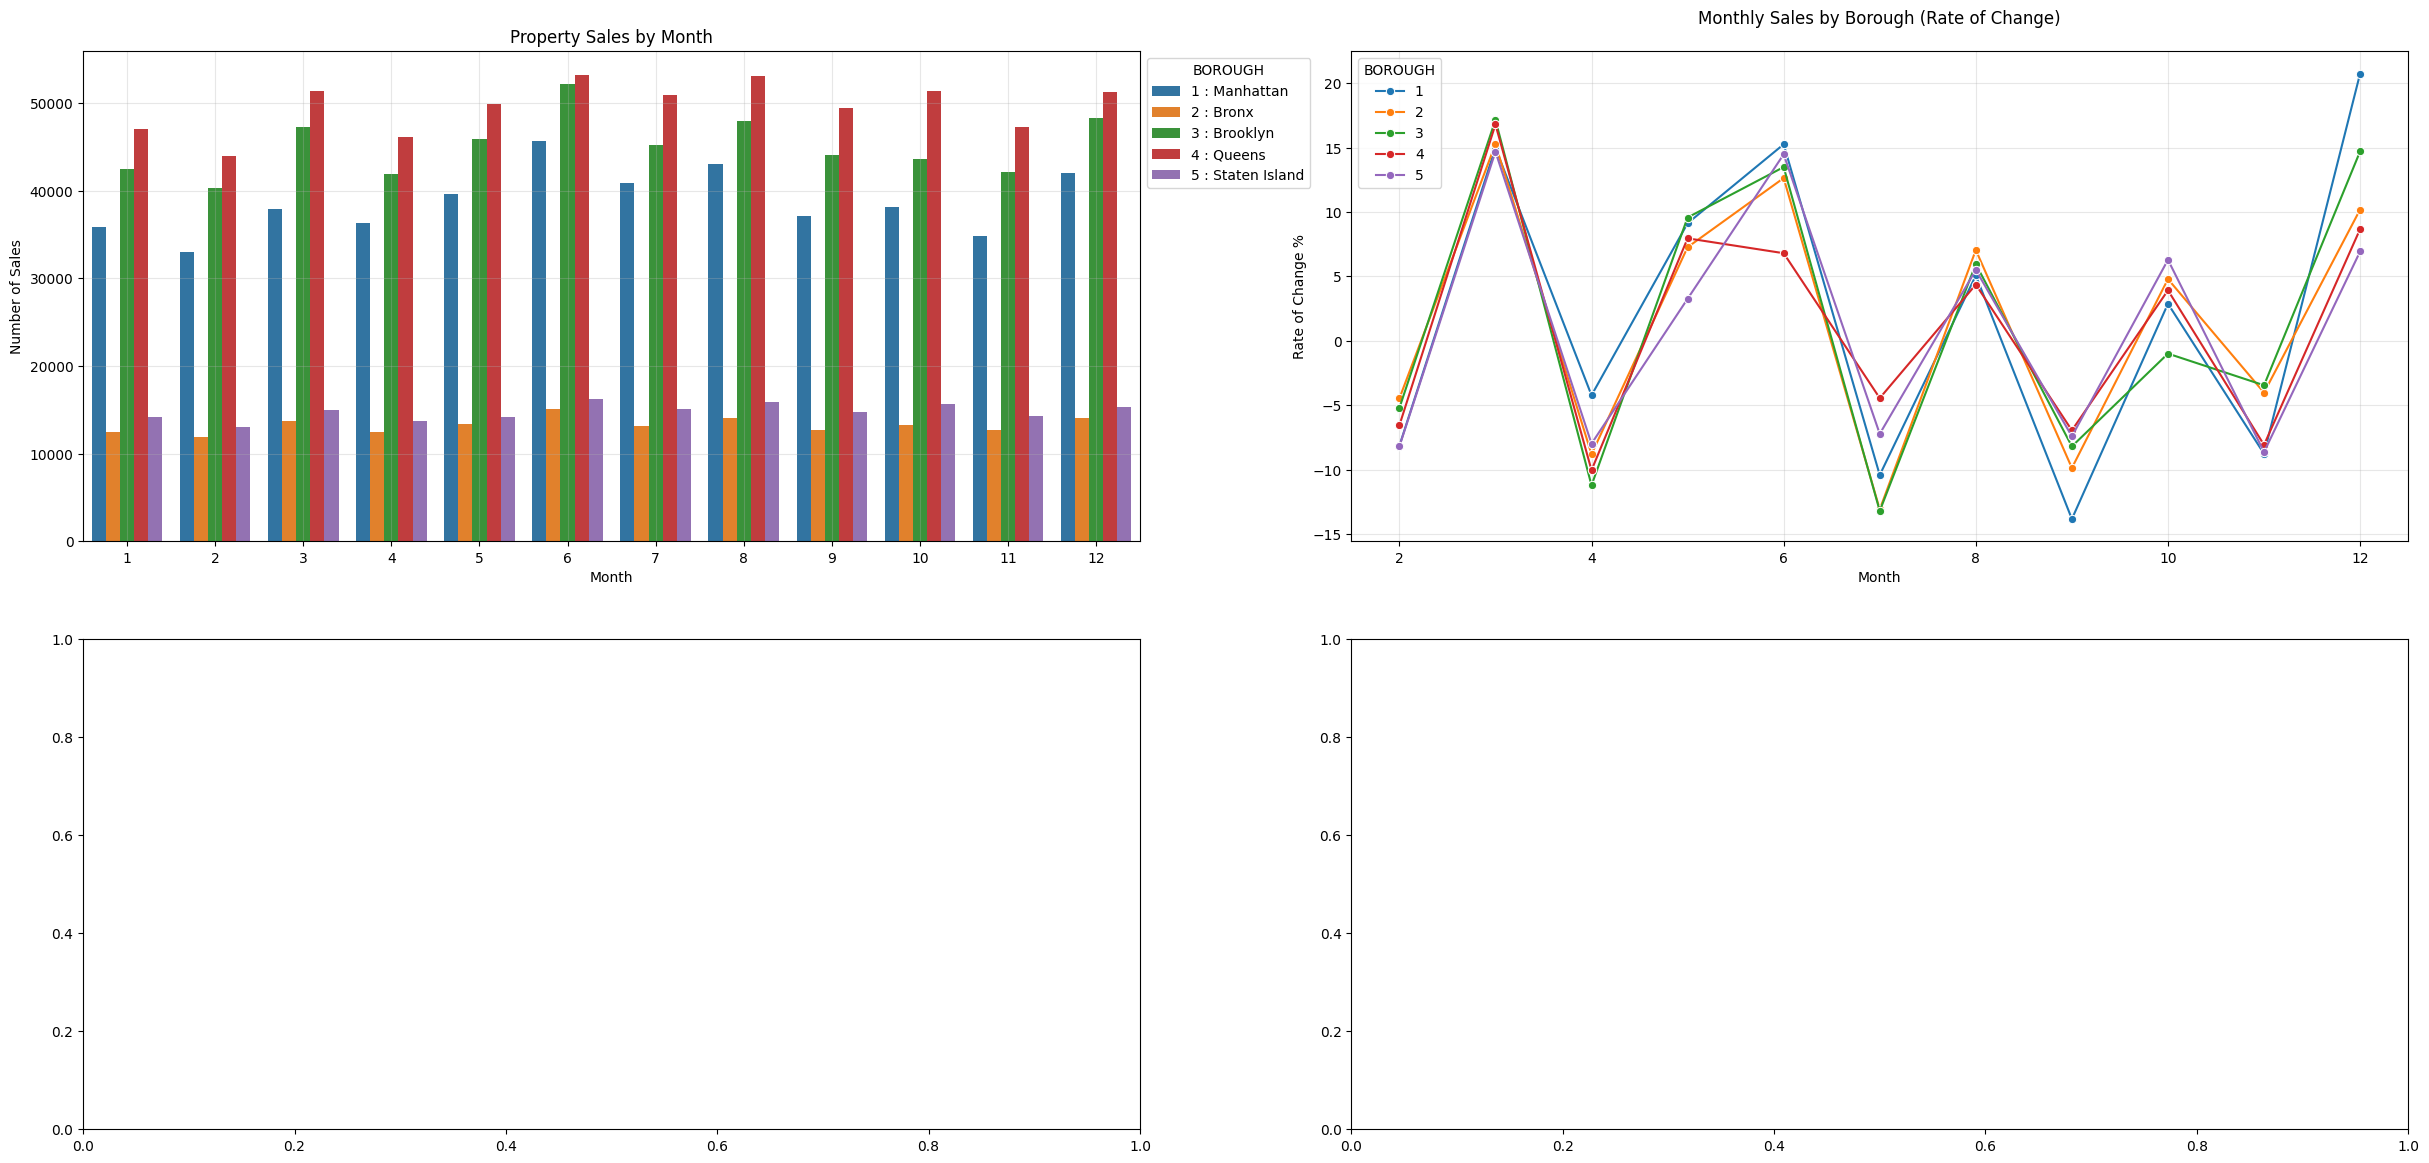

In [ ]:
fig, axs = plt.subplots(2,2)

query2 = """
SELECT EXTRACT(MONTH FROM "SALE DATE") as month,
    "BOROUGH",
    COUNT(*) as count
FROM rolling_sales
GROUP BY EXTRACT(MONTH FROM "SALE DATE"), "BOROUGH"
ORDER BY month, "BOROUGH"
"""

monthly_byBoro = pl.read_database(query = query2, connection = connection)
monthly_byBoro_roc = monthly_byBoro.sort("month").with_columns(
    (pl.col("count").pct_change().over("BOROUGH")*100).alias("roc")
) 

sns.barplot(
    data=monthly_byBoro.to_pandas(),
    x='month',
    y='count',
    hue='BOROUGH',
    palette=["C0", "C1", "C2", "C3", "C4"],
    ax=axs[0,0]
)

axs[0,0].set_title('Monthly Sales by Borough')
axs[0,0].set_xlabel('Month')
axs[0,0].set_ylabel('Number of Sales')
axs[0,0].grid(True, alpha=0.3)
sns.move_legend(
    axs[0,0], 
    "upper left",
    bbox_to_anchor=(1,1),
    labels=borough_names
)

sns.lineplot(
    data=monthly_byBoro_roc.to_pandas(),
    x='month',
    y='roc',
    hue='BOROUGH',
    palette=["C0", "C1", "C2", "C3", "C4"],
    marker='o',
    ax=axs[0,1]
)

axs[0,1].set_title('Monthly Sales by Borough (Rate of Change)', pad=20)
axs[0,1].set_xlabel('Month')
axs[0,1].set_ylabel('Rate of Change %')
axs[0,1].grid(True, alpha=0.3)



fig.set_figheight(14)
fig.set_figwidth(30)

<Axes: xlabel='year', ylabel='roc'>

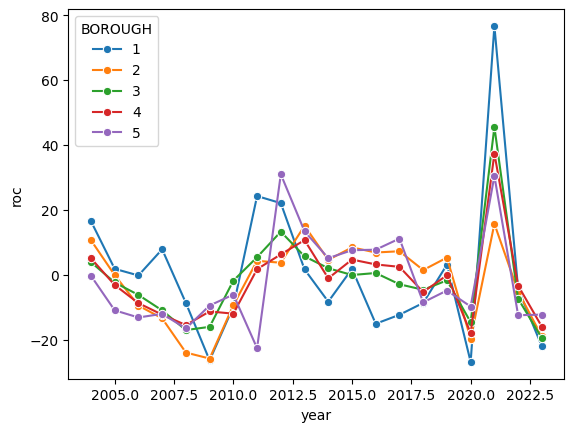

In [7]:
sns.lineplot(
    data=annual_byBoro_roc_pd,
    x='year',
    y='roc',
    hue='BOROUGH',
    palette=["C0", "C1", "C2", "C3", "C4"],
    marker='o',
    ax=None
)